### Ongoing GAN with celeba face data

In [1]:
from google.colab import auth
auth.authenticate_user()

import sys
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/Colab Notebooks/GAN/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/GAN


Data Donwload : https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg

In [55]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.utils as vutils

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [47]:
import cv2

im=cv2.imread("../../Data/faces_images/1/face_0.png")
im.shape

(128, 128, 3)

In [45]:
os.listdir("../../Data/faces_images/1/")

['face_0.png',
 'face_100.png',
 'face_1000.png',
 'face_1003.png',
 'face_1006.png',
 'face_1022.png',
 'face_1028.png',
 'face_1030.png',
 'face_1034.png',
 'face_104.png',
 'face_1042.png',
 'face_1043.png',
 'face_1045.png',
 'face_1047.png',
 'face_1057.png',
 'face_1063.png',
 'face_1070.png',
 'face_1075.png',
 'face_108.png',
 'face_1093.png',
 'face_1096.png',
 'face_1099.png',
 'face_11.png',
 'face_110.png',
 'face_1108.png',
 'face_1109.png',
 'face_1112.png',
 'face_1115.png',
 'face_1117.png',
 'face_1119.png',
 'face_1128.png',
 'face_1130.png',
 'face_1134.png',
 'face_1135.png',
 'face_1137.png',
 'face_114.png',
 'face_1145.png',
 'face_1151.png',
 'face_1157.png',
 'face_1159.png',
 'face_1164.png',
 'face_1167.png',
 'face_1173.png',
 'face_1184.png',
 'face_1185.png',
 'face_1189.png',
 'face_1193.png',
 'face_1196.png',
 'face_1198.png',
 'face_1202.png',
 'face_1214.png',
 'face_1222.png',
 'face_123.png',
 'face_1238.png',
 'face_1247.png',
 'face_1257.png',
 'f

In [56]:

dataroot = "../../Data/faces_images/"

dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader=DataLoader(dataset, batch_size=32, shuffle=True)

In [58]:
i, (img,d) = next(enumerate(dataloader))
print(i, img.shape, d)

0 torch.Size([32, 3, 64, 64]) tensor([3, 3, 0, 0, 2, 3, 1, 1, 1, 4, 3, 3, 0, 3, 3, 3, 4, 0, 0, 3, 4, 0, 0, 3,
        3, 3, 0, 0, 0, 0, 4, 3])


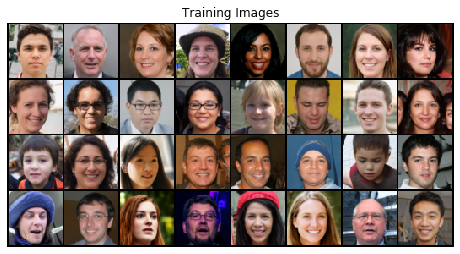

In [59]:
# Plot some training images
device=torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [90]:
img_shape = (3, 64, 64)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(64*64*3, 128),
            nn.BatchNorm1d(128, 0.8),
            nn.Linear(128,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [82]:
i, (img,d) = next(enumerate(dataloader))
valid = Variable(Tensor(img.size(0), 1).fill_(1.0), requires_grad=False)
valid.shape
fake = Variable(Tensor(img.size(0), 1).fill_(0.0), requires_grad=False)
real_imgs = Variable(img.type(Tensor))

In [83]:
valid.shape, fake.shape, real_imgs.shape

(torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 3, 64, 64]))

In [87]:
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 64*64*3))))
z.shape

torch.Size([32, 12288])

In [88]:
gen_imgs = generator(z)
gen_imgs.shape

torch.Size([32, 3, 64, 64])

1572864

In [ ]:
for epoch in range(30):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(torch.ones(imgs.size()[0])))
        fake = Variable(Tensor(torch.zeros(imgs.size()[0])))

        print(valid.shape, fake.shape)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        print(real_imgs.shape)


        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 64*64*3))))
        print("z : ", z.shape)

        # Generate a batch of images
        gen_imgs = generator(z)
        print("gen_imgs : ", gen_imgs.shape)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # print(
        #     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #     % (epoch, 30, i, len(dataloader), d_loss.item(), g_loss.item())
        # )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 400 == 0:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 30, i, len(dataloader), d_loss.item(), g_loss.item())
          )
            save_image(gen_imgs.data[:25], "%d.png" % batches_done, nrow=5, normalize=True)

In [63]:
i, (imgs,d) = next(enumerate(dataloader))
print(i, imgs.shape, d)
valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)

0 torch.Size([32, 3, 64, 64]) tensor([0, 3, 3, 4, 1, 4, 0, 0, 0, 3, 0, 3, 2, 0, 3, 3, 1, 3, 3, 3, 3, 4, 1, 5,
        3, 4, 3, 4, 0, 0, 0, 0])


In [66]:
valid = Variable(Tensor(imgs.size(0), 6).fill_(1.0), requires_grad=False)
valid.shape

torch.Size([32, 6])

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Activation, UpSampling2D, Reshape
import numpy as np

In [21]:
model = Sequential()
model.add(UpSampling2D())

In [29]:
X = np.asarray([[1, 2],[3, 4]])
# show input data for context
print(X)

[[1 2]
 [3 4]]


In [30]:
X.shape

(2, 2)

In [33]:
X=X.reshape(1,2,2,1)

In [40]:
X.shape

(1, 2, 2, 1)

In [41]:
model = Sequential()
model.add(UpSampling2D(input_shape=(2, 2, 1)))
# summarize the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_6 (UpSampling2 (None, 4, 4, 1)           0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [46]:
yhat = model.predict(X)
print(yhat)

[[[[1.]
   [1.]
   [2.]
   [2.]]

  [[1.]
   [1.]
   [2.]
   [2.]]

  [[3.]
   [3.]
   [4.]
   [4.]]

  [[3.]
   [3.]
   [4.]
   [4.]]]]


In [43]:
yhat.shape

(1, 4, 4, 1)

In [47]:
yhat = yhat.reshape((4, 4))
# summarize output
print(yhat)
print(yhat.shape)

[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]]
(4, 4)


In [53]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import UpSampling2D
from keras.layers import Conv2D
# define model
model = Sequential()
# define input shape, output enough activations for for 128 5x5 image
model.add(Dense(128 * 5 * 5, input_dim=100))
# reshape vector of activations into 128 feature maps with 5x5
model.add(Reshape((5, 5, 128)))
# double input from 128 5x5 to 1 10x10 feature map
model.add(UpSampling2D())
# fill in detail in the upsampled feature maps and output a single image
model.add(Conv2D(1, (3,3), padding='same'))
# summarize model
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3200)              323200    
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 5, 128)         0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 1)         1153      
Total params: 324,353
Trainable params: 324,353
Non-trainable params: 0
_________________________________________________________________
